#Loading Data

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import librosa as lr
import librosa.display
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import librosa.display
from IPython.display import Audio
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/KaggleToken"

In [ ]:
%cd /content/sample_data
!mkdir data
%cd /content/gdrive/MyDrive/KaggleToken

/content/sample_data
/content/gdrive/MyDrive/KaggleToken


In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

speech-emotion-recognition-en.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip speech-emotion-recognition-en.zip -d /content/sample_data/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/data/Crema/1088_IWW_FEA_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_IWW_HAP_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_IWW_NEU_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_IWW_SAD_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_ANG_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_DIS_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_FEA_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_HAP_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_NEU_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_SAD_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_ANG_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_DIS_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_FEA_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_HAP_XX.wav  
  inflating

#Loading Audio

In [ ]:
def LoadAudio(Crema):
    emotions = []
    timeLines=[]
    Audio_List=[]
    samp_freq=[]
    
    for wav in os.listdir(Crema):
        path=Crema+"/"+wav
        audio,sampling_freq=lr.load(path,sr=16000)
        yt, index = librosa.effects.trim(audio, top_db=60)       
        

        if len(yt) > (3*16000):
            yt = yt[:3*16000]
        else:
            padding = (3*16000) - len(yt)
            offset = padding // 2
            yt = np.pad(yt, (offset,3*16000- len(yt) - offset), 'constant')
        # yt=lr.util.normalize(yt)  

        mean = np.mean(yt)
        std = np.std(yt)
        out = np.ones( (len(yt)) ) 
        yt= np.divide((yt - mean),std,out=out, where=std!=0)
        # yt = (yt - mean) / std #normalization & standarization
        Audio_List.append(yt)
        samp_freq.append(sampling_freq)
        timeLines.append(np.arange(0,len(yt))/sampling_freq)
        info = wav.partition(".wav")[0].split("_")
        if info[2] == 'SAD':
            emotions.append(0)
        elif info[2] == 'ANG':
            emotions.append(1)
        elif info[2] == 'DIS':
            emotions.append(2)
        elif info[2] == 'FEA':
            emotions.append(3)
        elif info[2] == 'HAP':
            emotions.append(4)
        elif info[2] == 'NEU':
            emotions.append(5)
        else:
            emotions.append(6)
            
    return Audio_List,timeLines,samp_freq,emotions

In [ ]:
Audio_List,timeLines,samp_freq,Labels= LoadAudio("/content/sample_data/data/Crema")
print(len(Audio_List))
print(len(timeLines))
print(len(Labels)) 

7442
7442
7442


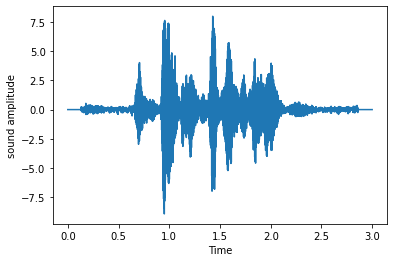

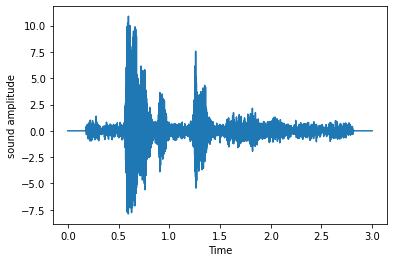

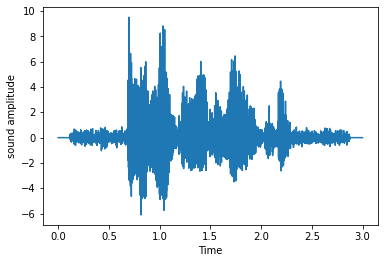

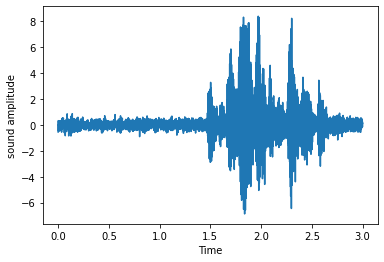

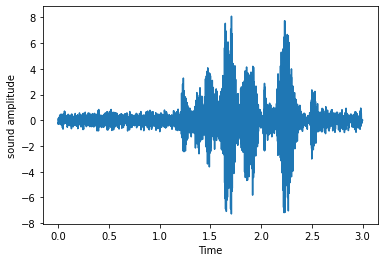

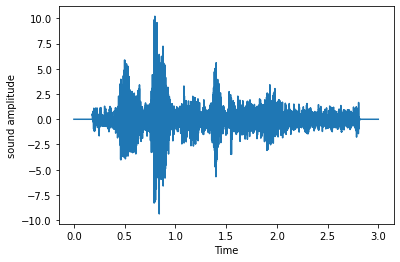

In [ ]:
emotions=[0,1,5,6,12,13]
for i in emotions:
    fig,ax=plt.subplots()
    ax.plot(timeLines[i],Audio_List[i])
    ax.set(xlabel='Time',ylabel='sound amplitude')
    plt.show()

In [ ]:
import IPython.display as ipd
emotions=[0,1,5,6,12,13]
for i in emotions:
  ipd.display(ipd.Audio(Audio_List[i],rate=16000))

#Data splitting

In [ ]:
 trainSet,testSet, labels_train, labels_test = train_test_split(Audio_List, Labels, test_size=0.30, random_state=42)
 print(len(trainSet))
 print(len(testSet))
 trainSet, valSet, labels_train, labels_val = train_test_split(trainSet, labels_train, test_size=0.05, random_state=42)
 print(len(trainSet))
 print(len(valSet))

5209
2233
4948
261


#Features Extraction and Augmentation for 2D CNN model - Mel Spectogram

In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 22.7MB 128kB/s 
     |████████████████████████████████| 2.3MB 33.6MB/s 


In [ ]:
train_Aug=[]
for i in range(len(trainSet)):
  train_Aug.append(trainSet[i])

print(len(train_Aug))
print(len(labels_train))
print(len(trainSet))

4948
4948
4948


In [ ]:
import tensorflow_io as tfio

def mel_spectrogram(train_Aug):   
    S = lr.feature.melspectrogram(train_Aug, sr=16000, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db=lr.power_to_db(S, ref=np.max)
    return mel_spec_db


In [ ]:
train_set_spectorgram = np.zeros((len(train_Aug)*2,128,94)) # mel spectrogram training ]
for i in range(len(train_Aug)):
  train_set_spectorgram[i]= mel_spectrogram(train_Aug[i])
  

[Text(0.5, 1.0, 'Mel-frequency spectrogram before Freq Mask')]

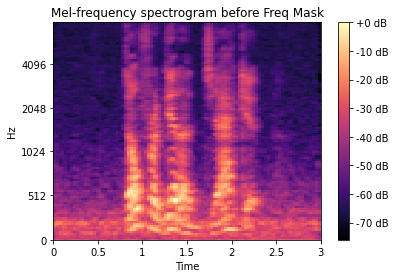

In [ ]:
fig, ax = plt.subplots()
mel_spectrogram = librosa.display.specshow(train_set_spectorgram[0], x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax)
fig.colorbar(mel_spectrogram, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram before Freq Mask')

In [ ]:
def freq_mask(mel_spec_db):    
    freq_mask = tfio.audio.freq_mask(mel_spec_db, param=10)
    return freq_mask
j=0
for i in range(len(train_Aug),len(train_Aug)*2):
  train_set_spectorgram[i]= freq_mask(train_set_spectorgram[j])
  labels_train.append(labels_train[j])
  j+=1

[Text(0.5, 1.0, 'Mel-frequency spectrogram after Freq Mask')]

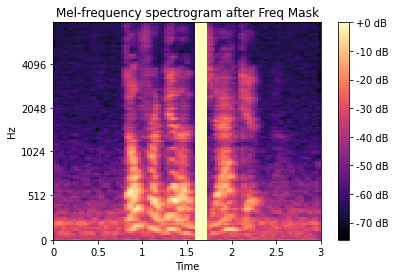

In [ ]:
fig2, ax2 = plt.subplots()
mel_spectrogramFM = librosa.display.specshow(train_set_spectorgram[len(train_Aug)], x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax2)
fig.colorbar(mel_spectrogramFM, ax=ax2, format='%+2.0f dB')
ax2.set(title='Mel-frequency spectrogram after Freq Mask')

In [ ]:
val_set_spectorgram = np.zeros((len(valSet),128,94))  # mel spectrogram val 
for audio in range(len(valSet)):
  S = lr.feature.melspectrogram(valSet[audio], sr=16000, n_fft=2048, hop_length=512, n_mels=128)
  mel_spec_db=lr.power_to_db(S, ref=np.max)
  val_set_spectorgram[audio] = mel_spec_db

In [ ]:
test_set_spectorgram = np.zeros((len(testSet),128,94))  # mel spectrogram test 
for audio in range(len(testSet)):
  S = lr.feature.melspectrogram(testSet[audio], sr=16000, n_fft=2048, hop_length=512, n_mels=128)
  mel_spec_db=lr.power_to_db(S, ref=np.max)
  test_set_spectorgram[audio] = mel_spec_db

In [ ]:
train_set_spectorgram = train_set_spectorgram[:,:,:,np.newaxis]
print(train_set_spectorgram.shape)
val_set_spectorgram = val_set_spectorgram[:,:,:,np.newaxis]
print(val_set_spectorgram.shape)
test_set_spectorgram = test_set_spectorgram[:,:,:,np.newaxis]
print(test_set_spectorgram.shape)

(9896, 128, 94, 1)
(261, 128, 94, 1)
(2233, 128, 94, 1)


#1st Model Trial
*   relu + l1 reg + RMSprop 
*   Validation Accuracy: 45.59%
* Test Accuracy 44.8%

In [ ]:
import glob
from random import shuffle

import librosa
import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
def get_2D_model():
    nclass =len(np.unique(Labels))
    inp = Input(shape=(128, 94, 1))
    norm_inp = BatchNormalization()(inp)
    img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1(0.01))(norm_inp)
    img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1(0.01))(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1(0.01))(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1(0.01))(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu,kernel_regularizer=l1(0.01))(img_1)
    img_1 = GlobalMaxPool2D()(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
  
    return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l1
model = get_2D_model()

model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=16, epochs=700, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)))
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)


In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(train_set_spectorgram), np.array(labels_train), verbose=0)
y_pred = model.predict(test_set_spectorgram)
report=metrics.classification_report(labels_test,np.argmax(y_pred,axis=1)) 
print(report)

matrix = metrics.confusion_matrix(labels_test ,np.argmax(y_pred,axis=1))
print(matrix)

print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test,np.argmax(y_pred,axis=1))*100)

              precision    recall  f1-score   support

           0       0.37      0.85      0.52       394
           1       0.81      0.43      0.56       385
           2       0.42      0.39      0.41       391
           3       0.44      0.40      0.42       374
           4       0.46      0.35      0.40       354
           5       0.49      0.22      0.31       335

    accuracy                           0.45      2233
   macro avg       0.50      0.44      0.43      2233
weighted avg       0.50      0.45      0.44      2233

[[336   2  29  21   3   3]
 [ 14 164  79  33  75  20]
 [153  14 154  33  19  18]
 [151   6  19 149  42   7]
 [ 64  17  42  79 123  29]
 [184   0  46  25   5  75]]
val accuracy: 45.59386968612671
train accuracy: 46.988680958747864
test accuracy 44.827586206896555


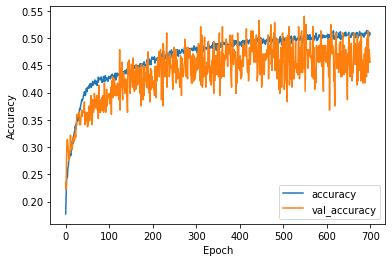

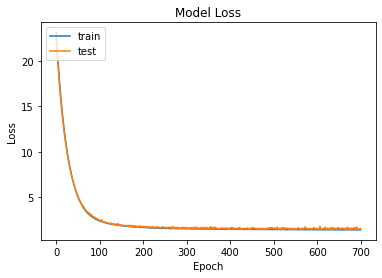

#2nd Model Trial
*   relu + l1_l2 reg + RMSprop 
*Using class weights to handle imbalance
* Trying to get out of stucking in local minimum
* Using ReduceLROnPlateau
*Validation Accuracy: 56.3%
*Test Accuracy: 57.09%

In [ ]:
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.regularizers import l1_l2
def get_2D_model():
    nclass =len(np.unique(Labels))
    inp = Input(shape=(128, 94, 1))
    norm_inp = BatchNormalization()(inp)
    img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(norm_inp)
    img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu,kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(img_1)
    img_1 = GlobalMaxPool2D()(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
    model.compile( loss = losses.sparse_categorical_crossentropy,optimizer = opt, metrics=['accuracy'])
    model.summary()
  
    return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l1
from tensorflow.keras import utils
from sklearn.utils import compute_class_weight

model = get_2D_model()
classWeight = compute_class_weight('balanced', np.unique(labels_train), labels_train) 
classWeight = dict(enumerate(classWeight))
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)


model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=16, epochs=1000, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)),class_weight=classWeight,callbacks=[lr_reduce])
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 94, 1)]      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 94, 1)        4         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 92, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 90, 16)       2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 30, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 41, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 28, 32)        4640  

              precision    recall  f1-score   support

           0       0.49      0.72      0.59       394
           1       0.74      0.67      0.70       385
           2       0.61      0.40      0.48       391
           3       0.47      0.50      0.48       374
           4       0.53      0.57      0.55       354
           5       0.69      0.56      0.62       335

    accuracy                           0.57      2233
   macro avg       0.59      0.57      0.57      2233
weighted avg       0.59      0.57      0.57      2233

[[284   6  25  49   6  24]
 [  8 258  18  21  68  12]
 [ 95  34 156  48  32  26]
 [ 98  12  10 186  58  10]
 [ 22  36  19  61 203  13]
 [ 67   4  26  32  18 188]]
val accuracy: 56.32184147834778
train accuracy: 62.803155183792114
test accuracy 57.09807433945365


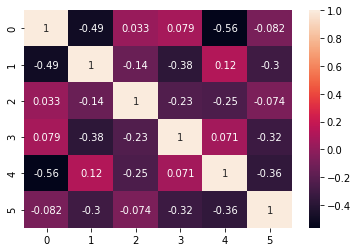

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(train_set_spectorgram), np.array(labels_train), verbose=0)
y_pred = model.predict(test_set_spectorgram)

report=metrics.classification_report(labels_test,np.argmax(y_pred,axis=1)) 
print(report)


matrix = metrics.confusion_matrix(labels_test ,np.argmax(y_pred,axis=1))
print(matrix)

df = pd.DataFrame(matrix,np.unique(Labels))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)

print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test,np.argmax(y_pred,axis=1))*100)

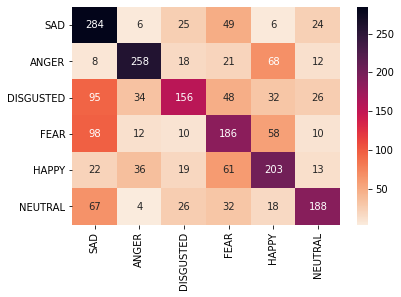

In [ ]:
import seaborn as sns
matrix = [[284,6,25,49,6,24],[8,258,18,21,68,12],[95,34,156,48,32,26],[98,  12,  10, 186,  58,  10],[22,  36,  19 , 61, 203,  13],[67   ,4  ,26  ,32 ,18,188]]
sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'],yticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'])


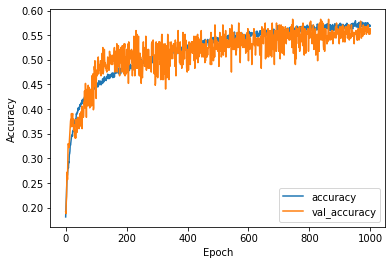

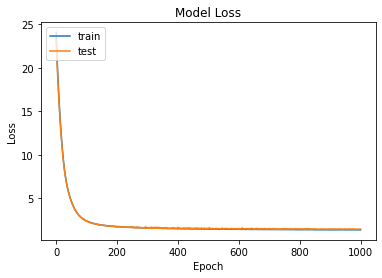

In [ ]:
plt.plot( model_history.history['accuracy'], label='accuracy')
plt.plot( model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()